In [1]:
pip install yfinance pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# index ticker definition (S&P500 index)
ticker = 'SPY'

# download historical data from yfinance
data = yf.download(ticker, start='2015-01-01', end='2023-01-01')

# 50-day and 200-day moving average
data['50_MA'] = data['Close'].rolling(window=50).mean()
data['200_MA'] = data['Close'].rolling(window=200).mean()

# calculate the RSI (for 14 days period)
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# calculate bollinger bands (20-days period)
data['20_MA'] = data['Close'].rolling(window=20).mean()
data['stddev'] = data['Close'].rolling(window=20).std()
data['Upper_Band'] = data['20_MA'] + (2 * data['stddev'])
data['Lower_Band'] = data['20_MA'] - (2 * data['stddev'])

[*********************100%***********************]  1 of 1 completed


In [4]:
# defining the buy/sell signals
data['Buy_Signal'] = ((data['50_MA'] > data['200_MA']) & (data['RSI'] < 30) & (data['Close'] < data['Lower_Band'])).astype(int)
data['Sell_Signal'] = ((data['50_MA'] < data['200_MA']) & (data['RSI'] > 70) & (data['Close'] > data['Upper_Band'])).astype(int)

In [5]:
initial_capital = 10000
capital = initial_capital
position = 0
portfolio_value = []
buy_and_hold_value = []
buy_and_hold_position = capital / data['Close'].iloc[0]

# iterate through historical data and apply the strategy
for i, row in data.iterrows():
    # track the buy and hold values
    buy_and_hold_value.append(buy_and_hold_position * row['Close'])

    # buy signal - if the buy signal is trigered and we don't have a position, buy
    if row['Buy_Signal'] == 1 and position == 0:
        position = capital / row['Close']
        capital = 0

    # sell signal - if sell signal is trigered and we have a posi
    elif row['Sell_Signal'] == 1 and position > 0:
        capital = position * row['Close']
        position = 0

    # track the portfolio value of the strategy
    if position > 0:
        portfolio_value.append(position * row['Close'])
    else:
        portfolio_value.append(capital)

data['Strategy_Portfolio_Value'] = portfolio_value
buy_and_hold_series = pd.Series(buy_and_hold_value, index=data.index)      

In [9]:
# Calculate strategy and buy-and-hold returns
data['Strategy_Returns'] = data['Strategy_Portfolio_Value'].pct_change()
data['Buy_and_Hold_Returns'] = buy_and_hold_series.pct_change()

# Sharpe Ratio (annualized)
strategy_sharpe_ratio = data['Strategy_Returns'].mean() / data['Strategy_Returns'].std() * np.sqrt(252)
buy_and_hold_sharpe_ratio = data['Buy_and_Hold_Returns'].mean() / data['Buy_and_Hold_Returns'].std() * np.sqrt(252)

# Max Drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

strategy_max_drawdown = max_drawdown(data['Strategy_Returns'].dropna())
buy_and_hold_max_drawdown = max_drawdown(data['Buy_and_Hold_Returns'].dropna())

# Print performance metrics
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
print(f"Buy-and-Hold Sharpe Ratio: {buy_and_hold_sharpe_ratio:.2f}")
print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
print(f"Buy-and-Hold Max Drawdown: {buy_and_hold_max_drawdown:.2%}")

Strategy Sharpe Ratio: 0.62
Buy-and-Hold Sharpe Ratio: 0.51
Strategy Max Drawdown: -34.10%
Buy-and-Hold Max Drawdown: -34.10%


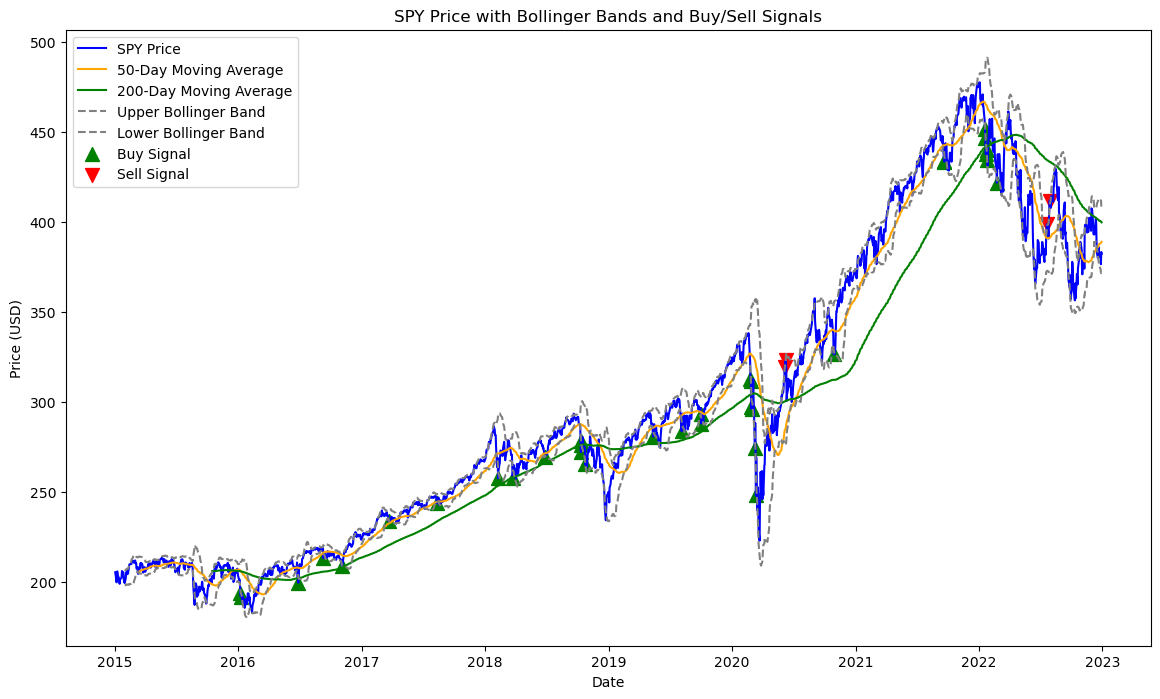

In [6]:
# plot the results
# price with buy/sell signals, moving averages, and 
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close'], label=f'{ticker} Price', color='blue')
plt.plot(data.index, data['50_MA'], label='50-Day Moving Average', color='orange')
plt.plot(data.index, data['200_MA'], label='200-Day Moving Average', color='green')
plt.plot(data.index, data['Upper_Band'], label='Upper Bollinger Band', color='gray', linestyle='--')
plt.plot(data.index, data['Lower_Band'], label='Lower Bollinger Band', color='grey', linestyle='--')
plt.scatter(data.index[data['Buy_Signal'] == 1], data['Close'][data['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green', s=100)
plt.scatter(data.index[data['Sell_Signal'] == 1], data['Close'][data['Sell_Signal'] == 1], label='Sell Signal', marker='v', color='red', s=100)
plt.title(f'{ticker} Price with Bollinger Bands and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='best')
plt.savefig('price_with_signals.png')
plt.show()

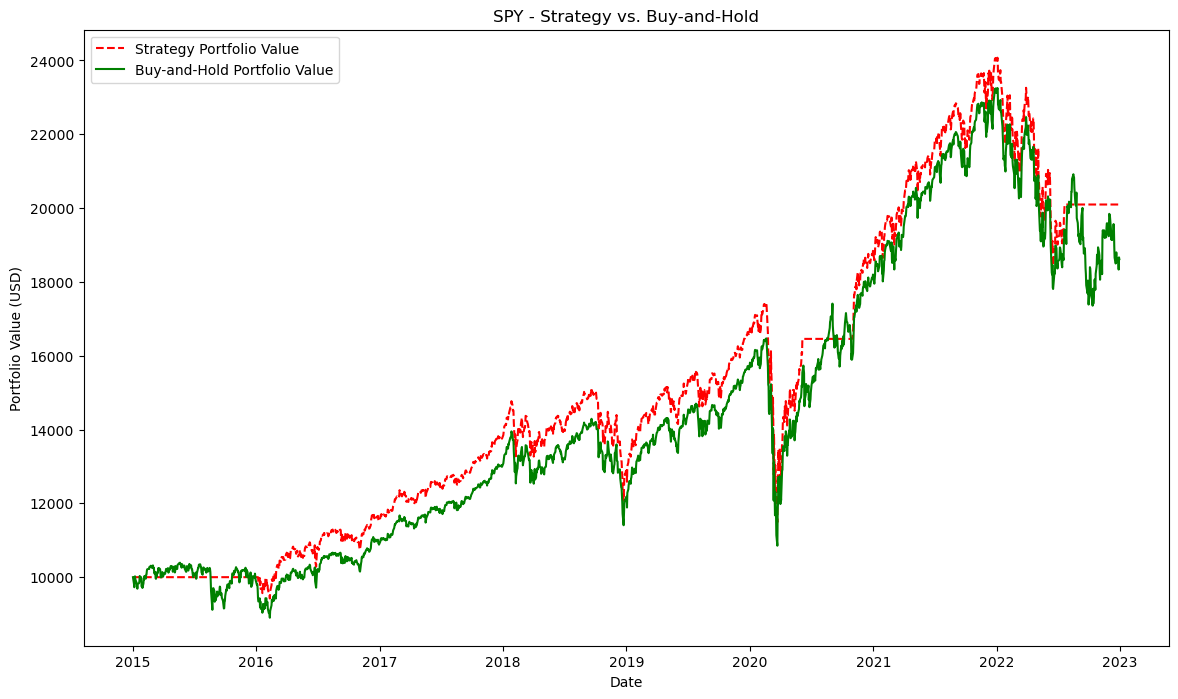

In [7]:
# Strategy vs. Buy-and-Hold Portfolio Value
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Strategy_Portfolio_Value'], label='Strategy Portfolio Value', linestyle='--', color='red')
plt.plot(data.index, buy_and_hold_value, label='Buy-and-Hold Portfolio Value', color='green')
plt.title(f'{ticker} - Strategy vs. Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend(loc='best')
plt.savefig('strategy_vs_buy_and_hold.png')
plt.show()

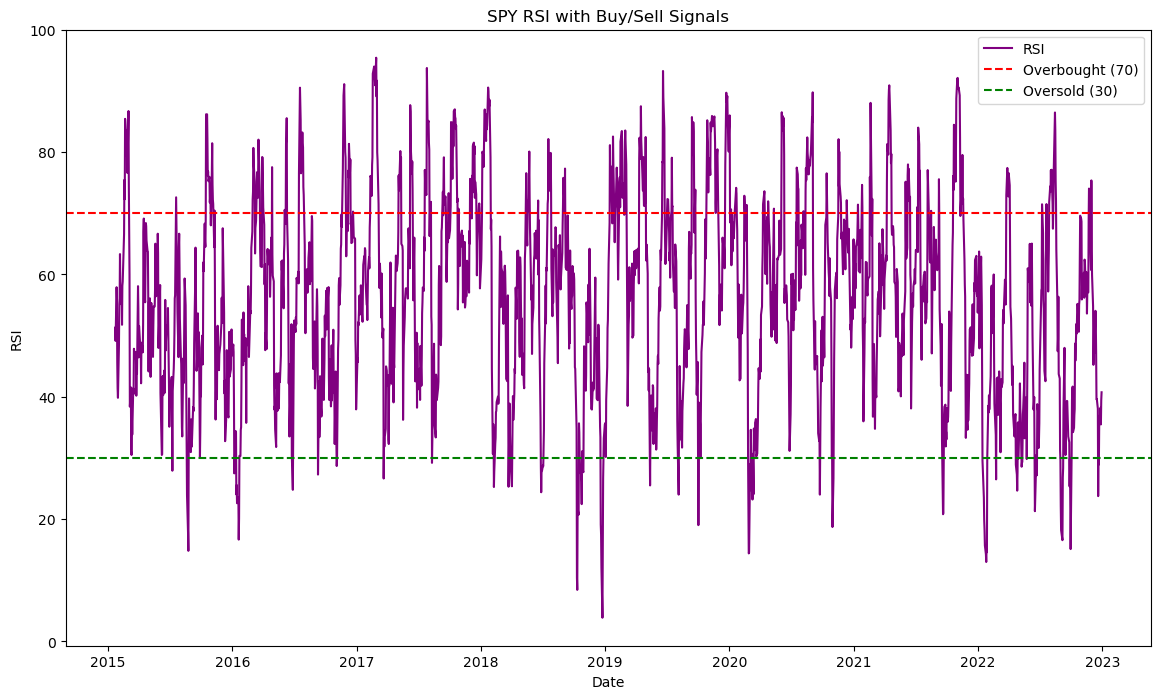

In [8]:
# RSI with Buy/Sell Signals
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title(f'{ticker} RSI with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend(loc='best')
plt.savefig('rsi_with_signals.png')
plt.show()